In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path1 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/x_train.npy"  # x_train
path2 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/y_train.npy"  # y_train
path3 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/x_test.npy"  # x_test
path4 = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/y_test.npy"  # y_test

In [3]:
from sklearn.metrics import accuracy_score
from PIL import Image
import copy
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torchvision
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

In [5]:
x_train = np.load(path1)
y_train = np.load(path2)
y_train = y_train.reshape(len(y_train))

x_test = np.load(path3)
y_test = np.load(path4)
y_test = y_test.reshape(len(y_test))

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [6]:
# It's a multi-class classification problem
class_index = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
               'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


![image](https://img-blog.csdnimg.cn/20190623084800880.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3lqcDE5ODcxMDEz,size_16,color_FFFFFF,t_70)

0


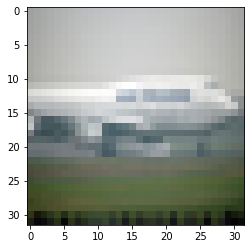

In [7]:
i = 100
plt.imshow(x_train[i])
print(y_train[i])

In [8]:
print(x_train[0].shape)

(32, 32, 3)


## Data preprocess

In [9]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize((256, 256)),
        # transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

img = Image.fromarray(x_train[100])
tmp = data_transforms['train'](img)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]

        if self.transform:
            X = self.transform(Image.fromarray(X))

        y = self.y[index]

        return X, y

    def __len__(self):
        return self.y.shape[0]

In [11]:
# split dataset
datasets = {}
train_size = 47000

datasets['train'] = CustomDataset(
    x_train[:train_size], y_train[:train_size], data_transforms['train'])
datasets['val'] = CustomDataset(
    x_train[train_size:], y_train[train_size:], data_transforms['val'])
datasets['test'] = CustomDataset(x_test, y_test, data_transforms['test'])

In [12]:
# show image in datasets
tmp_x, tmp_y = datasets['train'][1000]
#print(tmp_y)
# plt.imshow(tmp_x.permute(1, 2, 0))

In [13]:
dataloaders = {x: DataLoader(datasets[x], batch_size=512, shuffle=True)
               for x in ['train', 'val']}
dataloaders['test'] = DataLoader(
    datasets['test'], batch_size=2000, shuffle=False)
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
print(dataset_sizes['train'])
print(dataset_sizes['val'])
print(dataset_sizes['test'])

47000
3000
10000


## My Model

### Pretrained Model

In [15]:
model_conv = torchvision.models.resnet152(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=?)
optimizer_conv = optim.Adam(model_conv.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999),
                            eps=1e-08,
                            weight_decay=1e-5,
                            amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [16]:
summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### train model

In [17]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # if epoch > 1:
        #     for param in model.parameters():
        #         param.requires_grad = True

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # for param in model_conv.parameters():
                    #     print(param.requires_grad)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                del inputs
                del labels
                torch.cuda.empty_cache()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# train model
model_conv = train(model_conv, criterion, optimizer_conv,
                   exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8242 Acc: 0.7169
val Loss: 0.6182 Acc: 0.7807

Epoch 1/19
----------
train Loss: 0.4811 Acc: 0.8347
val Loss: 0.5730 Acc: 0.8030

Epoch 2/19
----------
train Loss: 0.3885 Acc: 0.8670
val Loss: 1.3412 Acc: 0.7450

Epoch 3/19
----------
train Loss: 0.4403 Acc: 0.8531
val Loss: 0.5578 Acc: 0.8153

Epoch 4/19
----------
train Loss: 0.2922 Acc: 0.9012
val Loss: 0.6769 Acc: 0.8267

Epoch 5/19
----------
train Loss: 0.2330 Acc: 0.9219
val Loss: 0.5894 Acc: 0.8270

Epoch 6/19
----------
train Loss: 0.1955 Acc: 0.9348
val Loss: 0.5921 Acc: 0.8167

Epoch 7/19
----------
train Loss: 0.1100 Acc: 0.9647
val Loss: 0.4837 Acc: 0.8557

Epoch 8/19
----------
train Loss: 0.0642 Acc: 0.9814
val Loss: 0.5018 Acc: 0.8570

Epoch 9/19
----------
train Loss: 0.0434 Acc: 0.9887
val Loss: 0.5445 Acc: 0.8590

Epoch 10/19
----------
train Loss: 0.0310 Acc: 0.9922
val Loss: 0.5366 Acc: 0.8627

Epoch 11/19
----------
train Loss: 0.0222 Acc: 0.9950
val Loss: 0.5830 Acc: 0.8573

Ep

### evaluate model

In [19]:
def predict(model):
    model.eval()
    y_pred = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            del inputs
            del labels
            torch.cuda.empty_cache()

            y_pred.extend(preds.tolist())
    return np.array(y_pred)

In [20]:
# Test score
y_pred = predict(model_conv)
print("Test Acc: ", accuracy_score(y_test, y_pred))

Test Acc:  0.8739


In [21]:
# PATH = "/content/drive/MyDrive/Current Workspace/Pattern Recognition/resnet152_wt.pth"
# torch.save(model_conv.state_dict(), PATH)